In [1]:
# import torch
# torch_version = torch.__version__.split('+')[0]  # e.g., '2.1.0'
# url = f"https://data.pyg.org/whl/torch-{torch_version}.html"

# # Now install with pip
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f {url}

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
import os

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import kneighbors_graph
import joblib

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [4]:
def build_data(X, y, k):
    knn = kneighbors_graph(X, n_neighbors=k, include_self=False)
    row, col = knn.nonzero()
    edge_index = torch.tensor([row, col], dtype=torch.long)
    return Data(x=torch.tensor(X, dtype=torch.float), edge_index=edge_index, y=torch.tensor(y, dtype=torch.long))

In [5]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [6]:
df = pd.read_csv("train.csv")
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
features_to_drop = [
    'bwd psh flags', 'bwd urg flags', 'fwd avg bytes/bulk',
    'fwd avg packets/bulk', 'fwd avg bulk rate', 'bwd avg bytes/bulk',
    'bwd avg packets/bulk', 'bwd avg bulk rate', 'fwd header length.1'
]

df.drop(columns=features_to_drop, axis=1,inplace=True)
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
features = [c for c in df.columns if c!='label']
X = df[features].values
y = df['label'].values

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

idx = np.arange(len(df))
train_idx, test_idx = train_test_split(idx, test_size=0.33, stratify=y, random_state=DEFAULT_RANDOM_SEED)
train_mask = torch.zeros(len(df), dtype=torch.bool); train_mask[train_idx]=True
test_mask = torch.zeros(len(df), dtype=torch.bool); test_mask[test_idx]=True

In [9]:
data = build_data(X_scaled, y, k=5)
data.train_mask, data.test_mask = train_mask, test_mask

d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program 

In [10]:
model = GraphNet(in_channels=X_scaled.shape[1], gcn_hidden=128, dnn_hidden=64, out_channels=2)
opt = optim.Adam(model.parameters(), lr=0.01); loss_fn = nn.CrossEntropyLoss()
for epoch in range(1,81):
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()

    if epoch % 10 == 0:
        model.eval()
        preds = out[data.test_mask].argmax(1)
        print(f"Epoch {epoch} | Loss {loss.item():.4f} | Test Acc {accuracy_score(data.y[data.test_mask], preds):.4f}")

Epoch 10 | Loss 0.1853 | Test Acc 0.9218
Epoch 20 | Loss 0.1206 | Test Acc 0.9465
Epoch 30 | Loss 0.1035 | Test Acc 0.9599
Epoch 40 | Loss 0.0903 | Test Acc 0.9651
Epoch 50 | Loss 0.0787 | Test Acc 0.9675
Epoch 60 | Loss 0.0752 | Test Acc 0.9709
Epoch 70 | Loss 0.0679 | Test Acc 0.9719
Epoch 80 | Loss 0.0606 | Test Acc 0.9753


In [11]:
joblib.dump(scaler, 'phase2_gnndnn_scaler.pkl')

['phase2_gnndnn_scaler.pkl']

In [12]:
w = model.gcn1.lin.weight.detach().cpu().numpy()
importance = np.mean(np.abs(w), axis=0)
imp_df = pd.DataFrame({'feature': features, 'importance': importance}).sort_values('importance', ascending=False)
top_n = 10
top_features = imp_df['feature'].iloc[:top_n].tolist()
print(f"Top {top_n} features:\n", imp_df.head(top_n))

Top 10 features:
                    feature  importance
35           bwd packets/s    0.163584
0         destination port    0.149241
57  init_win_bytes_forward    0.147161
15          flow packets/s    0.142946
11   bwd packet length min    0.142336
49           down/up ratio    0.138319
44          psh flag count    0.128038
59        act_data_pkt_fwd    0.127672
2        total fwd packets    0.126874
54       subflow fwd bytes    0.124396


In [13]:
idxs = [features.index(f) for f in top_features]
X_top = X_scaled[:, idxs]
new_data = build_data(X_top, y, k=5)
new_data.train_mask, new_data.test_mask = train_mask, test_mask

In [14]:
reduced = GraphNet(in_channels=len(idxs), gcn_hidden=128, dnn_hidden=64, out_channels=2)
opt2 = optim.Adam(reduced.parameters(), lr=0.01)
for epoch in range(1,81):
    reduced.train() 
    opt2.zero_grad()
    out2 = reduced(new_data.x, new_data.edge_index)
    loss2 = loss_fn(out2[new_data.train_mask], new_data.y[new_data.train_mask])
    loss2.backward()
    opt2.step()

In [15]:
reduced.eval()
preds2 = out2[new_data.test_mask].argmax(1)
print("Reduced Model Metrics:")
print(classification_report(new_data.y[new_data.test_mask], preds2, target_names=['Benign','Attack']))

Reduced Model Metrics:
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95     23185
      Attack       0.87      0.71      0.78      6011

    accuracy                           0.92     29196
   macro avg       0.90      0.84      0.86     29196
weighted avg       0.92      0.92      0.91     29196



In [16]:
torch.save(reduced.state_dict(), "GNN_DNN_top10.pth")

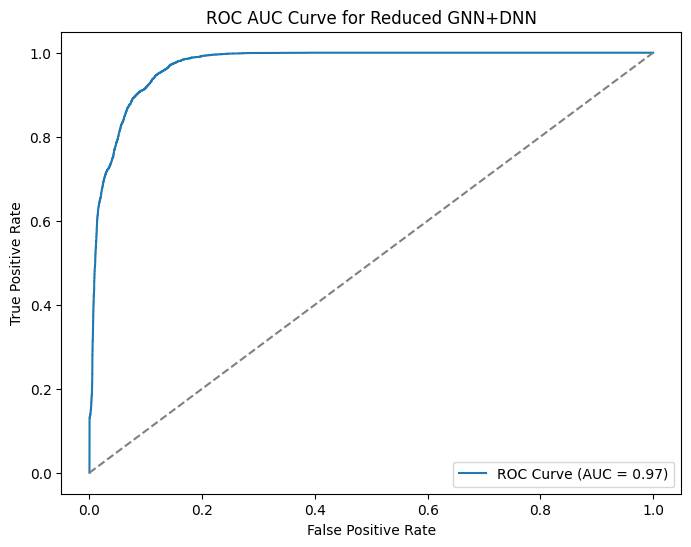

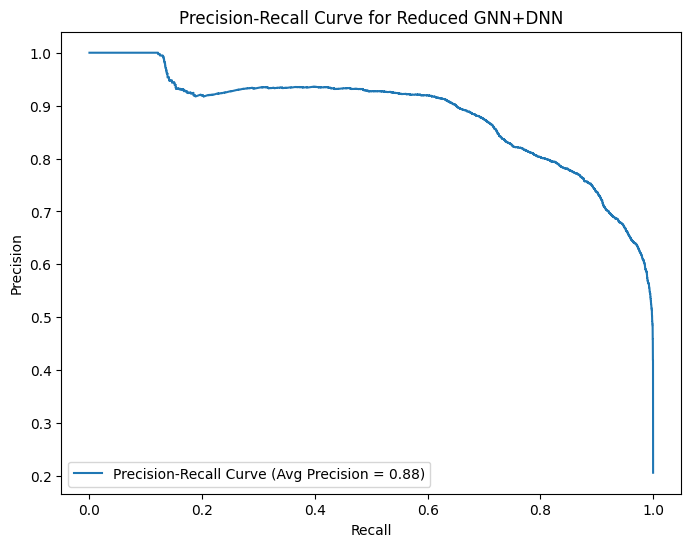

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

y_true_np = new_data.y[new_data.test_mask].cpu().detach().numpy()
y_scores = out2.detach().exp()[new_data.test_mask, 1].cpu().detach().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_np, y_scores)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Reduced GNN+DNN')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_np, y_scores)
avg_precision = average_precision_score(y_true_np, y_scores)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Reduced GNN+DNN')
plt.legend(loc='lower left')
plt.show()